<a href="https://colab.research.google.com/github/fjgr/IA_BigData/blob/main/SNS/DaCiberSalut/DaCiberSalut(dataset_completo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision timm numpy pillow gdown

In [ ]:
# Importamos librerías
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
import os
import zipfile
import gdown
from glob import glob
from shutil import copy2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Descargar y extraer dataset combinado (colon + pulmón)
url = "https://drive.google.com/uc?id=1VhvONYiexeSaReVATVbBsNS22UiB4Yqi"
zip_filename = "dataset.zip"
extract_dir = "/content/dataset"

gdown.download(url, zip_filename, quiet=False)
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Rutas originales
colon_dir = os.path.join(extract_dir, "colon_image_sets")
lung_dir = os.path.join(extract_dir, "lung_image_sets")

Downloading...
From (original): https://drive.google.com/uc?id=1VhvONYiexeSaReVATVbBsNS22UiB4Yqi
From (redirected): https://drive.google.com/uc?id=1VhvONYiexeSaReVATVbBsNS22UiB4Yqi&confirm=t&uuid=cd97daee-865d-40df-b0cc-78f0514415a9
To: /content/dataset.zip
100%|██████████| 1.89G/1.89G [00:21<00:00, 89.5MB/s]


In [ ]:
# Crear estructura unificada
UNIFIED_DATASET = "/content/unified_dataset"
TRAIN_DIR = os.path.join(UNIFIED_DATASET, "train")
VAL_DIR = os.path.join(UNIFIED_DATASET, "val")
TEST_DIR = os.path.join(UNIFIED_DATASET, "test")
CLASSES = ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]
for folder in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    for class_name in CLASSES:
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)

# Unir imágenes por clase
ORIGINS = {
    "colon_aca": os.path.join(colon_dir, "colon_aca"),
    "colon_n": os.path.join(colon_dir, "colon_n"),
    "lung_aca": os.path.join(lung_dir, "lung_aca"),
    "lung_n": os.path.join(lung_dir, "lung_n"),
    "lung_scc": os.path.join(lung_dir, "lung_scc"),
}

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

for class_name, path in ORIGINS.items():
    image_paths = glob(os.path.join(path, '*.jpeg'))
    image_paths.sort()
    n = len(image_paths)
    n_train = int(n * TRAIN_RATIO)
    n_val = int(n * VAL_RATIO)

    for img in image_paths[:n_train]:
        copy2(img, os.path.join(TRAIN_DIR, class_name))
    for img in image_paths[n_train:n_train+n_val]:
        copy2(img, os.path.join(VAL_DIR, class_name))
    for img in image_paths[n_train+n_val:]:
        copy2(img, os.path.join(TEST_DIR, class_name))

# Transformaciones
IMG_SIZE = 768
BATCH_SIZE = 8
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Modelo EfficientNet-B4
model = timm.create_model("efficientnet_b4", pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, len(CLASSES))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

In [ ]:
# Entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)


Epoch 1/5, Loss: 0.1387
Epoch 2/5, Loss: 0.0185
Epoch 3/5, Loss: 0.0072
Epoch 4/5, Loss: 0.0079
Epoch 5/5, Loss: 0.0071


In [ ]:
# Evaluación
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = correct / total
    return acc, all_preds, all_labels

train_acc, _, _ = evaluate_model(model, train_loader)
val_acc, _, _ = evaluate_model(model, val_loader)
test_acc, test_preds, test_labels = evaluate_model(model, test_loader)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 1.0000
Validation Accuracy: 0.9996
Test Accuracy: 0.9996


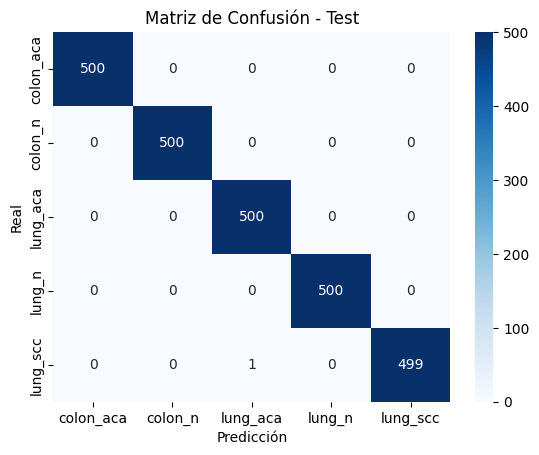

In [ ]:
# Matriz de confusión
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Test")
plt.show()


In [ ]:
# Guardar modelo
torch.save(model.state_dict(), "efficientnet_b4_colon_lung.pth")
